# Import and Config

In [ ]:
from typing import Tuple
import pandas as pd
import spacy
import numpy as np
from spacy.tokens import Token, Doc
from sentence_transformers import SentenceTransformer
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from discofuzz.constants import SIMILARITY_METRICS

from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

import seaborn as sns
import wget as wget
import zipfile

# Import DisCoFuzz package classes
from discofuzz.constants import *
from discofuzz.config import *
from discofuzz.WiCDatasetHandler import WiCDatasetHandler
from discofuzz.BaseEmbeddingModel import BaseEmbeddingModel
from discofuzz.DisCoFuzz import DisCoFuzz

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igeek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igeek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU available: {gpus}")

In [ ]:
sample_size = 10000
# Define all available similarity metrics from FourierFuzzifier
sim_metrics_enum = [SIMILARITY_METRICS.COS, SIMILARITY_METRICS.W1, SIMILARITY_METRICS.W2, SIMILARITY_METRICS.Q]
sim_metrics = [s.value for s in sim_metrics_enum]
n_components = 64
fuzzification_kernel_size = 16

# load config vars or defaults
X_train, y_train, X_test, y_test = WiCDatasetHandler.load_dataset(".", sample_size=sample_size)
sim_metrics = [s.value for s in sim_metrics_enum]
embedding_model = BaseEmbeddingModel()
model = DisCoFuzz(embedding_model)

# Run model

In [ ]:
X_train = model.fit(X_train)

In [ ]:
X_train = model.predict_batch(X_train, STRATEGIES)

# Evaluate model

In [16]:
def normalize_about_median(data):
    data = (data - data.min()) / (data.max() - data.min())
    return data - data.median()

## Get relatedness scores

In [ ]:
sims_df = pd.DataFrame()

# Add sentence embedding baseline (full sentence encoding)
sent_emb_sims = list()
for i, row in X_train.iterrows():
  sent_emb_sims.append(cosine_similarity(
      row["sent_1_embedding"].reshape((1, -1)),
      row["sent_2_embedding"].reshape((1, -1)),
  ))
  
sims_df["sent_emb_cos_sim"] = normalize_about_median(pd.Series(np.array(sent_emb_sims).reshape(-1, )))

In [ ]:
# get compositional embeddings for glosses using:
#   ALL composition strategies,
#   ALL similarity metrics
for sim_metric in sim_metrics_enum:
  print(f"\n\t=== Computing similarities with {sim_metric} metric ===")
  for s in STRATEGIES:
    print(f"\t\tGetting compositional embedding relatedness scores for {s} approach...")
    sims = list()
    for i, row in X_train.iterrows():
      try:
        sims.append(model.fuzzifier.similarity(
            row[DisCoFuzz._get_fuzzy_emb_col(s, 1)],
            row[DisCoFuzz._get_fuzzy_emb_col(s, 2)],
            method=sim_metric,
        ))
      except Exception as e:
        print(row)
        raise e
    
    col = f"fuzzy_{s}_PCA_{sim_metric.value}_sim"
    # normalize similarity scores
    sims_df[col] = normalize_about_median(pd.Series(sims))


	=== Computing similarities with SIMILARITY_METRICS.COS metric ===
		Getting compositional embedding relatedness scores for None approach...
		Getting compositional embedding relatedness scores for mean approach...
		Getting compositional embedding relatedness scores for intersection+mean approach...
		Getting compositional embedding relatedness scores for intersection+union approach...
		Getting compositional embedding relatedness scores for intersection+intersection approach...
		Getting compositional embedding relatedness scores for selective_intersection+mean approach...
		Getting compositional embedding relatedness scores for selective_intersection+union approach...
		Getting compositional embedding relatedness scores for selective_intersection+intersection+mean approach...

	=== Computing similarities with SIMILARITY_METRICS.W1 metric ===
		Getting compositional embedding relatedness scores for None approach...
		Getting compositional embedding relatedness scores for mean approa

C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:295: ComplexWarning: Casting complex values to real discards the imaginary part
  a = np.asarray(a, dtype=np.float64)
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:296: ComplexWarning: Casting complex values to real discards the imaginary part
  b = np.asarray(b, dtype=np.float64)
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:332: UserWarning: Problem infeasible. Check that a and b are in the simplex
  result_code_string = check_result(result_code)
C:\Users\igeek\OneDrive\Documents\GitHub\DisCoFuzz\src\discofuzz\fuzzy_classes\FourierFuzzifier.py:134: UserWarning: Input histogram consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure your input histogram consists of floating point elements.
  plan = ot.emd(


		Getting compositional embedding relatedness scores for mean approach...


C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:295: ComplexWarning: Casting complex values to real discards the imaginary part
  a = np.asarray(a, dtype=np.float64)
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:296: ComplexWarning: Casting complex values to real discards the imaginary part
  b = np.asarray(b, dtype=np.float64)
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:332: UserWarning: Problem infeasible. Check that a and b are in the simplex
  result_code_string = check_result(result_code)
C:\Users\igeek\OneDrive\Documents\GitHub\DisCoFuzz\src\discofuzz\fuzzy_classes\FourierFuzzifier.py:134: UserWarning: Input histogram consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure your input histogram consists of floating point elements.
  plan = ot.emd(


		Getting compositional embedding relatedness scores for intersection+mean approach...


C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:295: ComplexWarning: Casting complex values to real discards the imaginary part
  a = np.asarray(a, dtype=np.float64)
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:296: ComplexWarning: Casting complex values to real discards the imaginary part
  b = np.asarray(b, dtype=np.float64)
C:\Users\igeek\OneDrive\Documents\GitHub\DisCoFuzz\src\discofuzz\fuzzy_classes\FourierFuzzifier.py:134: UserWarning: Input histogram consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure your input histogram consists of floating point elements.
  plan = ot.emd(
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:332: UserWarning: Problem infeasible. Check that a and b are in the simplex
  result_code_string = check_result(result_code)


		Getting compositional embedding relatedness scores for intersection+union approach...


C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:295: ComplexWarning: Casting complex values to real discards the imaginary part
  a = np.asarray(a, dtype=np.float64)
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:296: ComplexWarning: Casting complex values to real discards the imaginary part
  b = np.asarray(b, dtype=np.float64)
C:\Users\igeek\OneDrive\Documents\GitHub\DisCoFuzz\src\discofuzz\fuzzy_classes\FourierFuzzifier.py:134: UserWarning: Input histogram consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure your input histogram consists of floating point elements.
  plan = ot.emd(
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:332: UserWarning: Problem infeasible. Check that a and b are in the simplex
  result_code_string = check_result(result_code)


		Getting compositional embedding relatedness scores for intersection+intersection approach...


C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:295: ComplexWarning: Casting complex values to real discards the imaginary part
  a = np.asarray(a, dtype=np.float64)
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:296: ComplexWarning: Casting complex values to real discards the imaginary part
  b = np.asarray(b, dtype=np.float64)
C:\Users\igeek\OneDrive\Documents\GitHub\DisCoFuzz\src\discofuzz\fuzzy_classes\FourierFuzzifier.py:134: UserWarning: Input histogram consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure your input histogram consists of floating point elements.
  plan = ot.emd(
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:332: UserWarning: Problem infeasible. Check that a and b are in the simplex
  result_code_string = check_result(result_code)


		Getting compositional embedding relatedness scores for selective_intersection+mean approach...


C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:295: ComplexWarning: Casting complex values to real discards the imaginary part
  a = np.asarray(a, dtype=np.float64)
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:296: ComplexWarning: Casting complex values to real discards the imaginary part
  b = np.asarray(b, dtype=np.float64)
C:\Users\igeek\OneDrive\Documents\GitHub\DisCoFuzz\src\discofuzz\fuzzy_classes\FourierFuzzifier.py:134: UserWarning: Input histogram consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure your input histogram consists of floating point elements.
  plan = ot.emd(
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:332: UserWarning: Problem infeasible. Check that a and b are in the simplex
  result_code_string = check_result(result_code)


		Getting compositional embedding relatedness scores for selective_intersection+union approach...


C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:295: ComplexWarning: Casting complex values to real discards the imaginary part
  a = np.asarray(a, dtype=np.float64)
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:296: ComplexWarning: Casting complex values to real discards the imaginary part
  b = np.asarray(b, dtype=np.float64)
C:\Users\igeek\OneDrive\Documents\GitHub\DisCoFuzz\src\discofuzz\fuzzy_classes\FourierFuzzifier.py:134: UserWarning: Input histogram consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure your input histogram consists of floating point elements.
  plan = ot.emd(
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:332: UserWarning: Problem infeasible. Check that a and b are in the simplex
  result_code_string = check_result(result_code)


		Getting compositional embedding relatedness scores for selective_intersection+intersection+mean approach...


C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:295: ComplexWarning: Casting complex values to real discards the imaginary part
  a = np.asarray(a, dtype=np.float64)
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:296: ComplexWarning: Casting complex values to real discards the imaginary part
  b = np.asarray(b, dtype=np.float64)
C:\Users\igeek\OneDrive\Documents\GitHub\DisCoFuzz\src\discofuzz\fuzzy_classes\FourierFuzzifier.py:134: UserWarning: Input histogram consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure your input histogram consists of floating point elements.
  plan = ot.emd(
C:\Users\igeek\AppData\Roaming\Python\Python312\site-packages\ot\lp\_network_simplex.py:332: UserWarning: Problem infeasible. Check that a and b are in the simplex
  result_code_string = check_result(result_code)



	=== Computing similarities with SIMILARITY_METRICS.Q metric ===
		Getting compositional embedding relatedness scores for None approach...
		Getting compositional embedding relatedness scores for mean approach...
		Getting compositional embedding relatedness scores for intersection+mean approach...
		Getting compositional embedding relatedness scores for intersection+union approach...
		Getting compositional embedding relatedness scores for intersection+intersection approach...
		Getting compositional embedding relatedness scores for selective_intersection+mean approach...
		Getting compositional embedding relatedness scores for selective_intersection+union approach...
		Getting compositional embedding relatedness scores for selective_intersection+intersection+mean approach...


In [20]:
sims_df.head()

,fuzzy_None_PCA_cos_sim,fuzzy_mean_PCA_cos_sim,fuzzy_intersection+mean_PCA_cos_sim,fuzzy_intersection+union_PCA_cos_sim,fuzzy_intersection+intersection_PCA_cos_sim,fuzzy_selective_intersection+mean_PCA_cos_sim,fuzzy_selective_intersection+union_PCA_cos_sim,fuzzy_selective_intersection+intersection+mean_PCA_cos_sim,fuzzy_None_PCA_wasserstein-1_sim,fuzzy_mean_PCA_wasserstein-1_sim,...,fuzzy_selective_intersection+intersection+mean_PCA_wasserstein-2_sim,fuzzy_None_PCA_quantum_sim,fuzzy_mean_PCA_quantum_sim,fuzzy_intersection+mean_PCA_quantum_sim,fuzzy_intersection+union_PCA_quantum_sim,fuzzy_intersection+intersection_PCA_quantum_sim,fuzzy_selective_intersection+mean_PCA_quantum_sim,fuzzy_selective_intersection+union_PCA_quantum_sim,fuzzy_selective_intersection+intersection+mean_PCA_quantum_sim,sent_emb_cos_sim
0,0.080596,-0.023593,0.002897,0.007416,0.007416,0.003947,0.003310,0.003947,-0.139926,-0.110394,...,-0.000010,-0.210659,-0.135382,-0.003507,-0.004329,-0.004329,0.001554,0.000100,0.001554,-0.124524
1,-0.005800,0.007871,0.000927,0.024273,0.024273,0.003365,0.001720,0.003365,-0.138908,0.028986,...,0.011291,-0.174923,0.036609,-0.000774,-0.014350,-0.014350,0.004116,0.000911,0.004116,-0.122760
2,-0.166447,-0.069141,-0.000559,0.005225,0.005225,0.003959,0.003369,0.003959,-0.038415,-0.279201,...,-0.000080,-0.037212,-0.358861,-0.002252,-0.003529,-0.003529,0.000473,-0.000286,0.000473,-0.082443
3,-0.049837,-0.021677,0.000440,0.000347,0.000347,-0.083281,-0.077047,-0.083281,-0.046928,-0.049607,...,-0.106599,-0.069822,-0.034579,0.000233,0.000492,0.000492,-0.038129,-0.008137,-0.038129,-0.101951
4,0.232676,0.142097,0.001145,0.001398,0.001398,-0.150246,-0.156178,-0.150246,0.235077,0.296196,...,-0.227999,0.294313,0.222110,-0.001844,-0.002076,-0.002076,-0.032098,-0.007801,-0.032098,0.275158


In [22]:
sims_df["sbert_token_avg_cos_sim"] = normalize_about_median(pd.Series(np.array(sbert_token_avg_sims).reshape(-1, )))

sims_df["is_related"] = train_labels["is_related"].values

In [23]:
sims_df.head()

,fuzzy_None_PCA_cos_sim,fuzzy_mean_PCA_cos_sim,fuzzy_intersection+mean_PCA_cos_sim,fuzzy_intersection+union_PCA_cos_sim,fuzzy_intersection+intersection_PCA_cos_sim,fuzzy_selective_intersection+mean_PCA_cos_sim,fuzzy_selective_intersection+union_PCA_cos_sim,fuzzy_selective_intersection+intersection+mean_PCA_cos_sim,fuzzy_None_PCA_wasserstein-1_sim,fuzzy_mean_PCA_wasserstein-1_sim,...,fuzzy_mean_PCA_quantum_sim,fuzzy_intersection+mean_PCA_quantum_sim,fuzzy_intersection+union_PCA_quantum_sim,fuzzy_intersection+intersection_PCA_quantum_sim,fuzzy_selective_intersection+mean_PCA_quantum_sim,fuzzy_selective_intersection+union_PCA_quantum_sim,fuzzy_selective_intersection+intersection+mean_PCA_quantum_sim,sent_emb_cos_sim,sbert_token_avg_cos_sim,is_related
0,0.080596,-0.023593,0.002897,0.007416,0.007416,0.003947,0.003310,0.003947,-0.139926,-0.110394,...,-0.135382,-0.003507,-0.004329,-0.004329,0.001554,0.000100,0.001554,-0.124524,-0.154867,0
1,-0.005800,0.007871,0.000927,0.024273,0.024273,0.003365,0.001720,0.003365,-0.138908,0.028986,...,0.036609,-0.000774,-0.014350,-0.014350,0.004116,0.000911,0.004116,-0.122760,-0.057215,0
2,-0.166447,-0.069141,-0.000559,0.005225,0.005225,0.003959,0.003369,0.003959,-0.038415,-0.279201,...,-0.358861,-0.002252,-0.003529,-0.003529,0.000473,-0.000286,0.000473,-0.082443,-0.278227,0
3,-0.049837,-0.021677,0.000440,0.000347,0.000347,-0.083281,-0.077047,-0.083281,-0.046928,-0.049607,...,-0.034579,0.000233,0.000492,0.000492,-0.038129,-0.008137,-0.038129,-0.101951,-0.022025,1
4,0.232676,0.142097,0.001145,0.001398,0.001398,-0.150246,-0.156178,-0.150246,0.235077,0.296196,...,0.222110,-0.001844,-0.002076,-0.002076,-0.032098,-0.007801,-0.032098,0.275158,0.036613,0


## Classify predictions based on similarity thresholding

In [24]:
sim_eval_df = pd.DataFrame()
for col in sims_df.columns:
    if col == "is_related":
        continue
    # normaize the 
    sim_eval_df[f"{col}_pred"] = sims_df[col] > 0
sim_eval_df["is_related"] = sims_df["is_related"]
sim_eval_df.head()

,fuzzy_None_PCA_cos_sim_pred,fuzzy_mean_PCA_cos_sim_pred,fuzzy_intersection+mean_PCA_cos_sim_pred,fuzzy_intersection+union_PCA_cos_sim_pred,fuzzy_intersection+intersection_PCA_cos_sim_pred,fuzzy_selective_intersection+mean_PCA_cos_sim_pred,fuzzy_selective_intersection+union_PCA_cos_sim_pred,fuzzy_selective_intersection+intersection+mean_PCA_cos_sim_pred,fuzzy_None_PCA_wasserstein-1_sim_pred,fuzzy_mean_PCA_wasserstein-1_sim_pred,...,fuzzy_mean_PCA_quantum_sim_pred,fuzzy_intersection+mean_PCA_quantum_sim_pred,fuzzy_intersection+union_PCA_quantum_sim_pred,fuzzy_intersection+intersection_PCA_quantum_sim_pred,fuzzy_selective_intersection+mean_PCA_quantum_sim_pred,fuzzy_selective_intersection+union_PCA_quantum_sim_pred,fuzzy_selective_intersection+intersection+mean_PCA_quantum_sim_pred,sent_emb_cos_sim_pred,sbert_token_avg_cos_sim_pred,is_related
0,True,False,True,True,True,True,True,True,False,False,...,False,False,False,False,True,True,True,False,False,0
1,False,True,True,True,True,True,True,True,False,True,...,True,False,False,False,True,True,True,False,False,0
2,False,False,False,True,True,True,True,True,False,False,...,False,False,False,False,True,False,True,False,False,0
3,False,False,True,True,True,False,False,False,False,False,...,False,True,True,True,False,False,False,False,False,1
4,True,True,True,True,True,False,False,False,True,True,...,True,False,False,False,False,False,False,True,True,0


## Visualize similarities

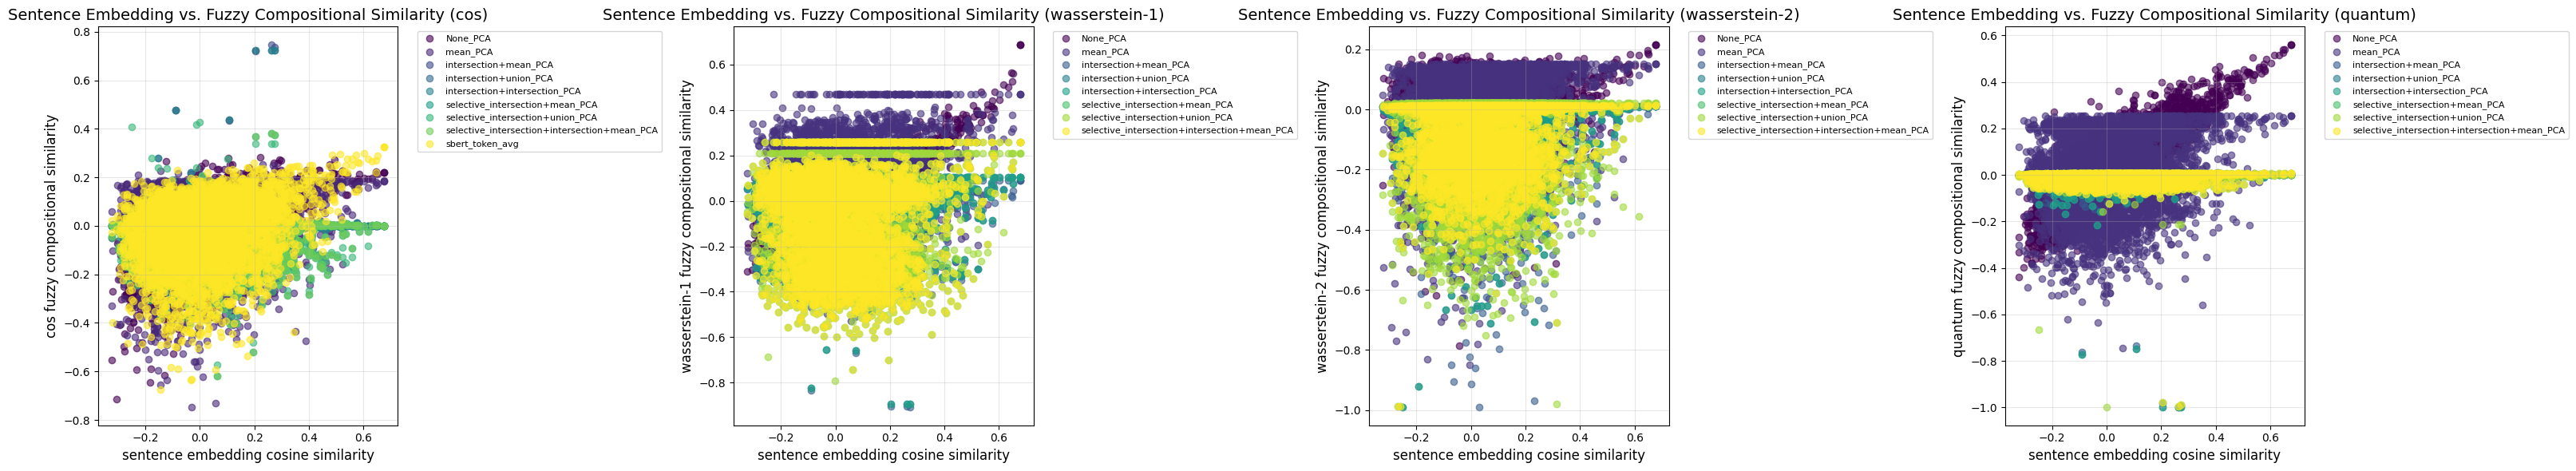

In [25]:
# Create subplots for each similarity metric
fig, axes = plt.subplots(
    1,
    len(sim_metrics),
    figsize=(8*len(sim_metrics), 6)
)
if len(sim_metrics) == 1:
    axes = [axes]

for metric_idx, sim_metric in enumerate(sim_metrics):
    ax = axes[metric_idx]
    
    # Get columns for this metric
    metric_cols = [col for col in sims_df.columns if col.endswith(f"{sim_metric}_sim")]
    
    cmap = plt.get_cmap("viridis")
    colors = cmap(np.linspace(0, 1, len(metric_cols)))
    
    for i, col in enumerate(metric_cols):
        if col == "sent_emb_cos_sim":
            continue
        ax.scatter(
            x=sims_df["sent_emb_cos_sim"],
            y=sims_df[col],
            color=colors[i],
            label=col.replace(f"fuzzy_", "").replace(f"_{sim_metric}_sim", ""),
            alpha=0.6
        )
    
    ax.set_xlabel("sentence embedding cosine similarity", fontsize=12)
    ax.set_ylabel(f"{sim_metric} fuzzy compositional similarity", fontsize=12)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    # ax.set_yscale("log")
    ax.set_title(f"Sentence Embedding vs. Fuzzy Compositional Similarity ({sim_metric})", fontsize=14)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Confusion Matrix

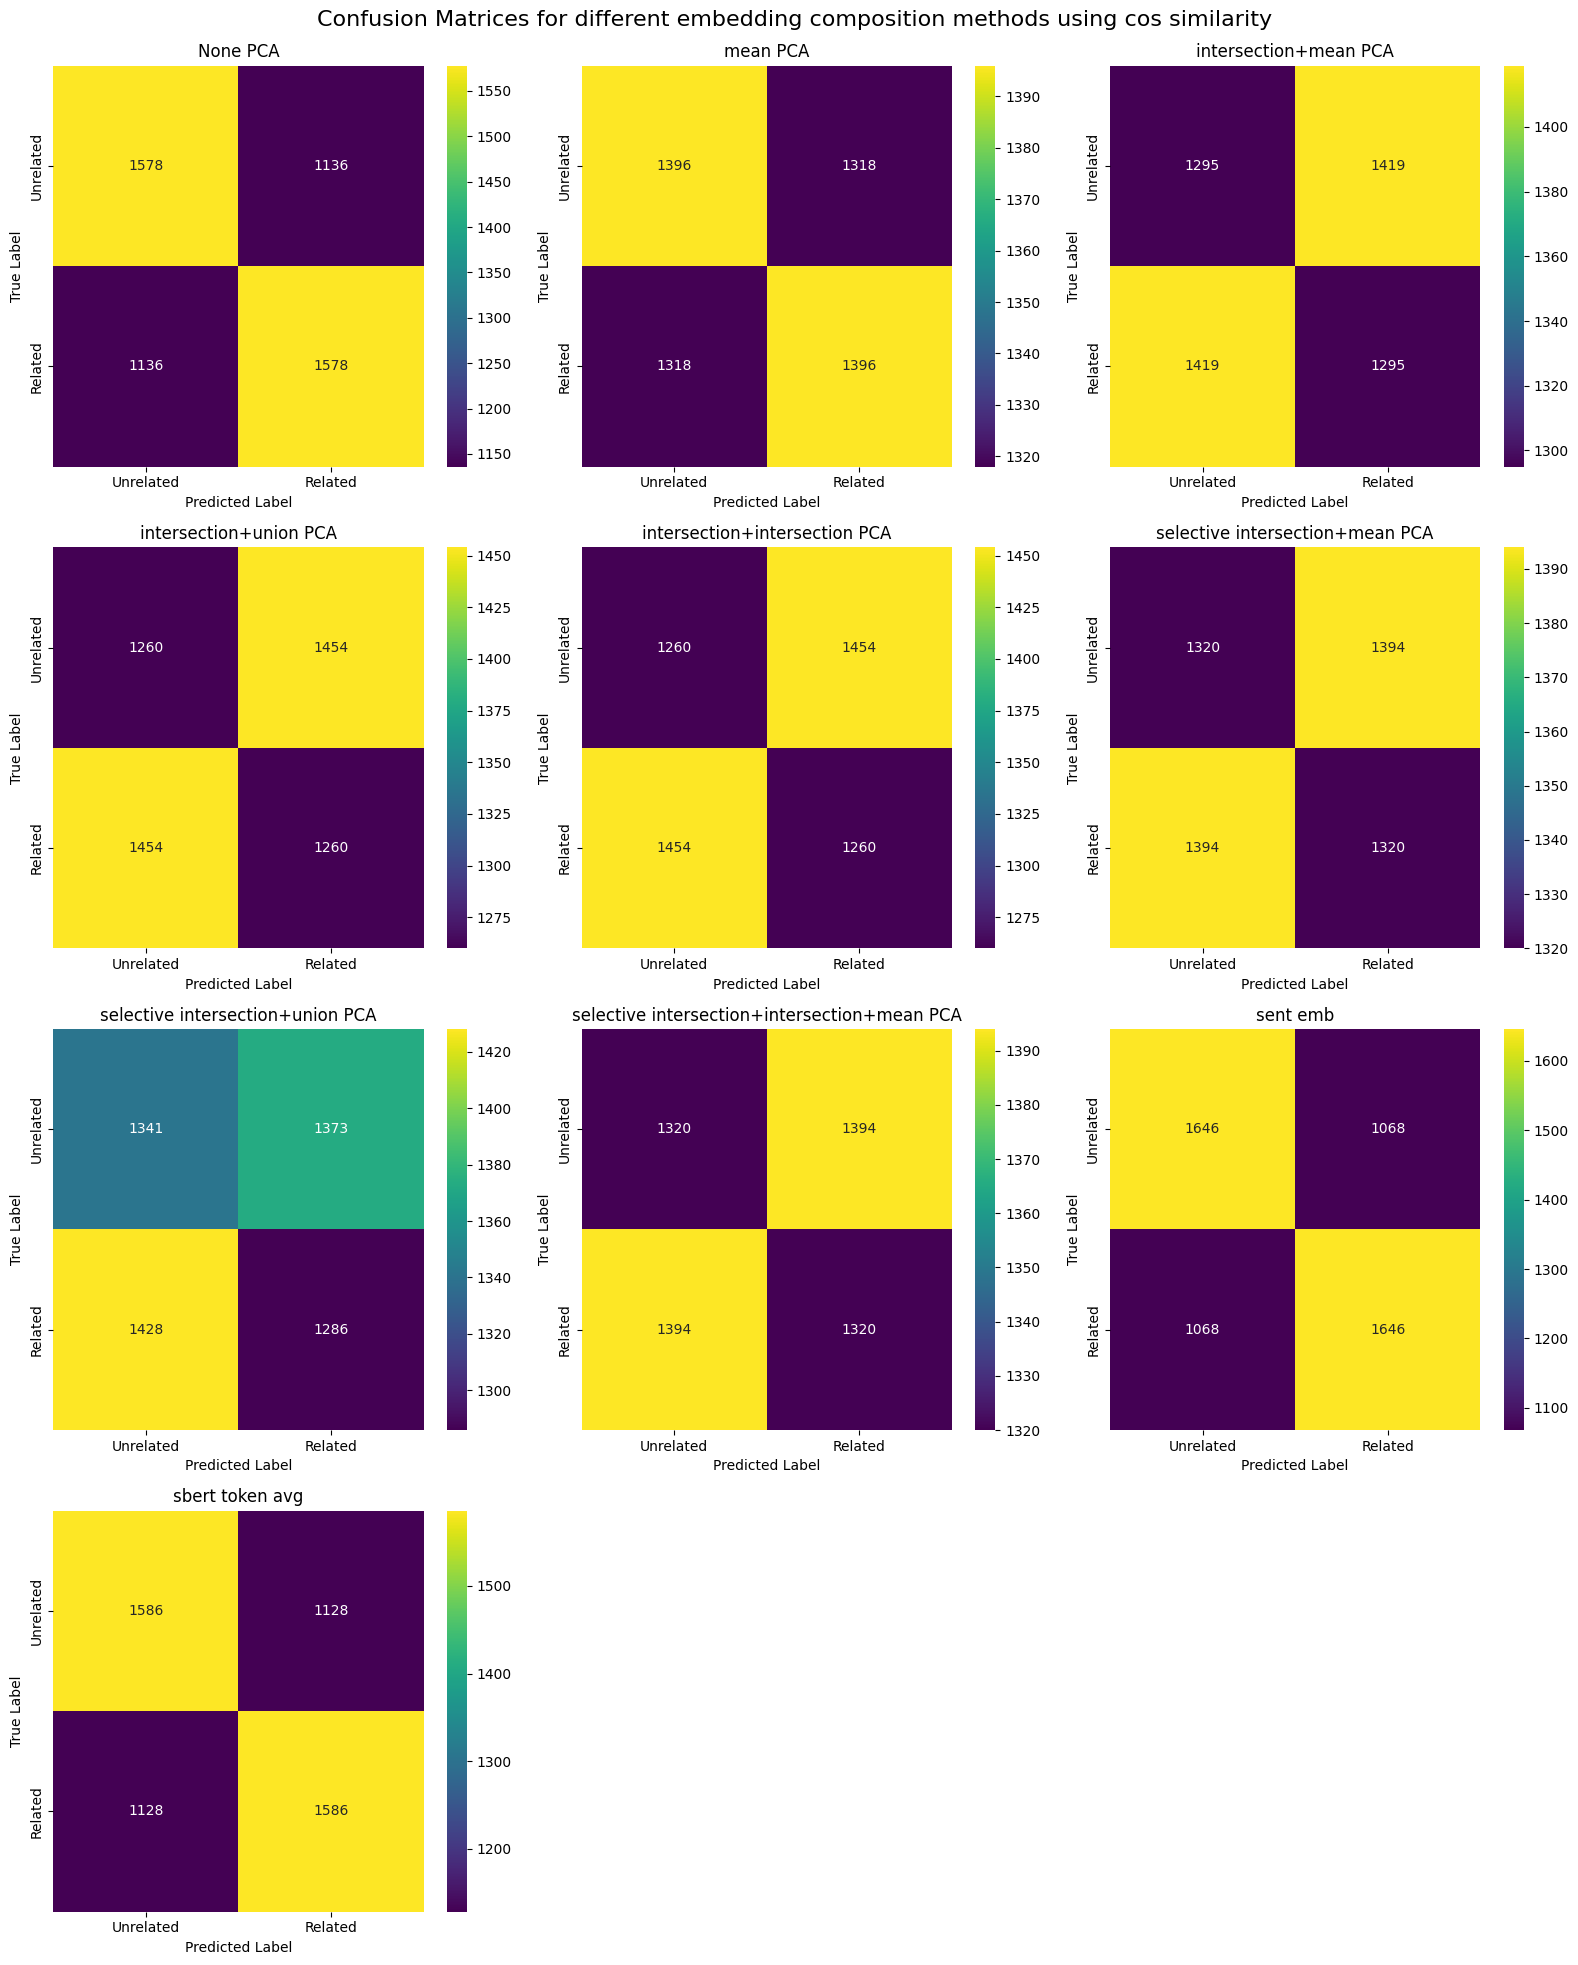

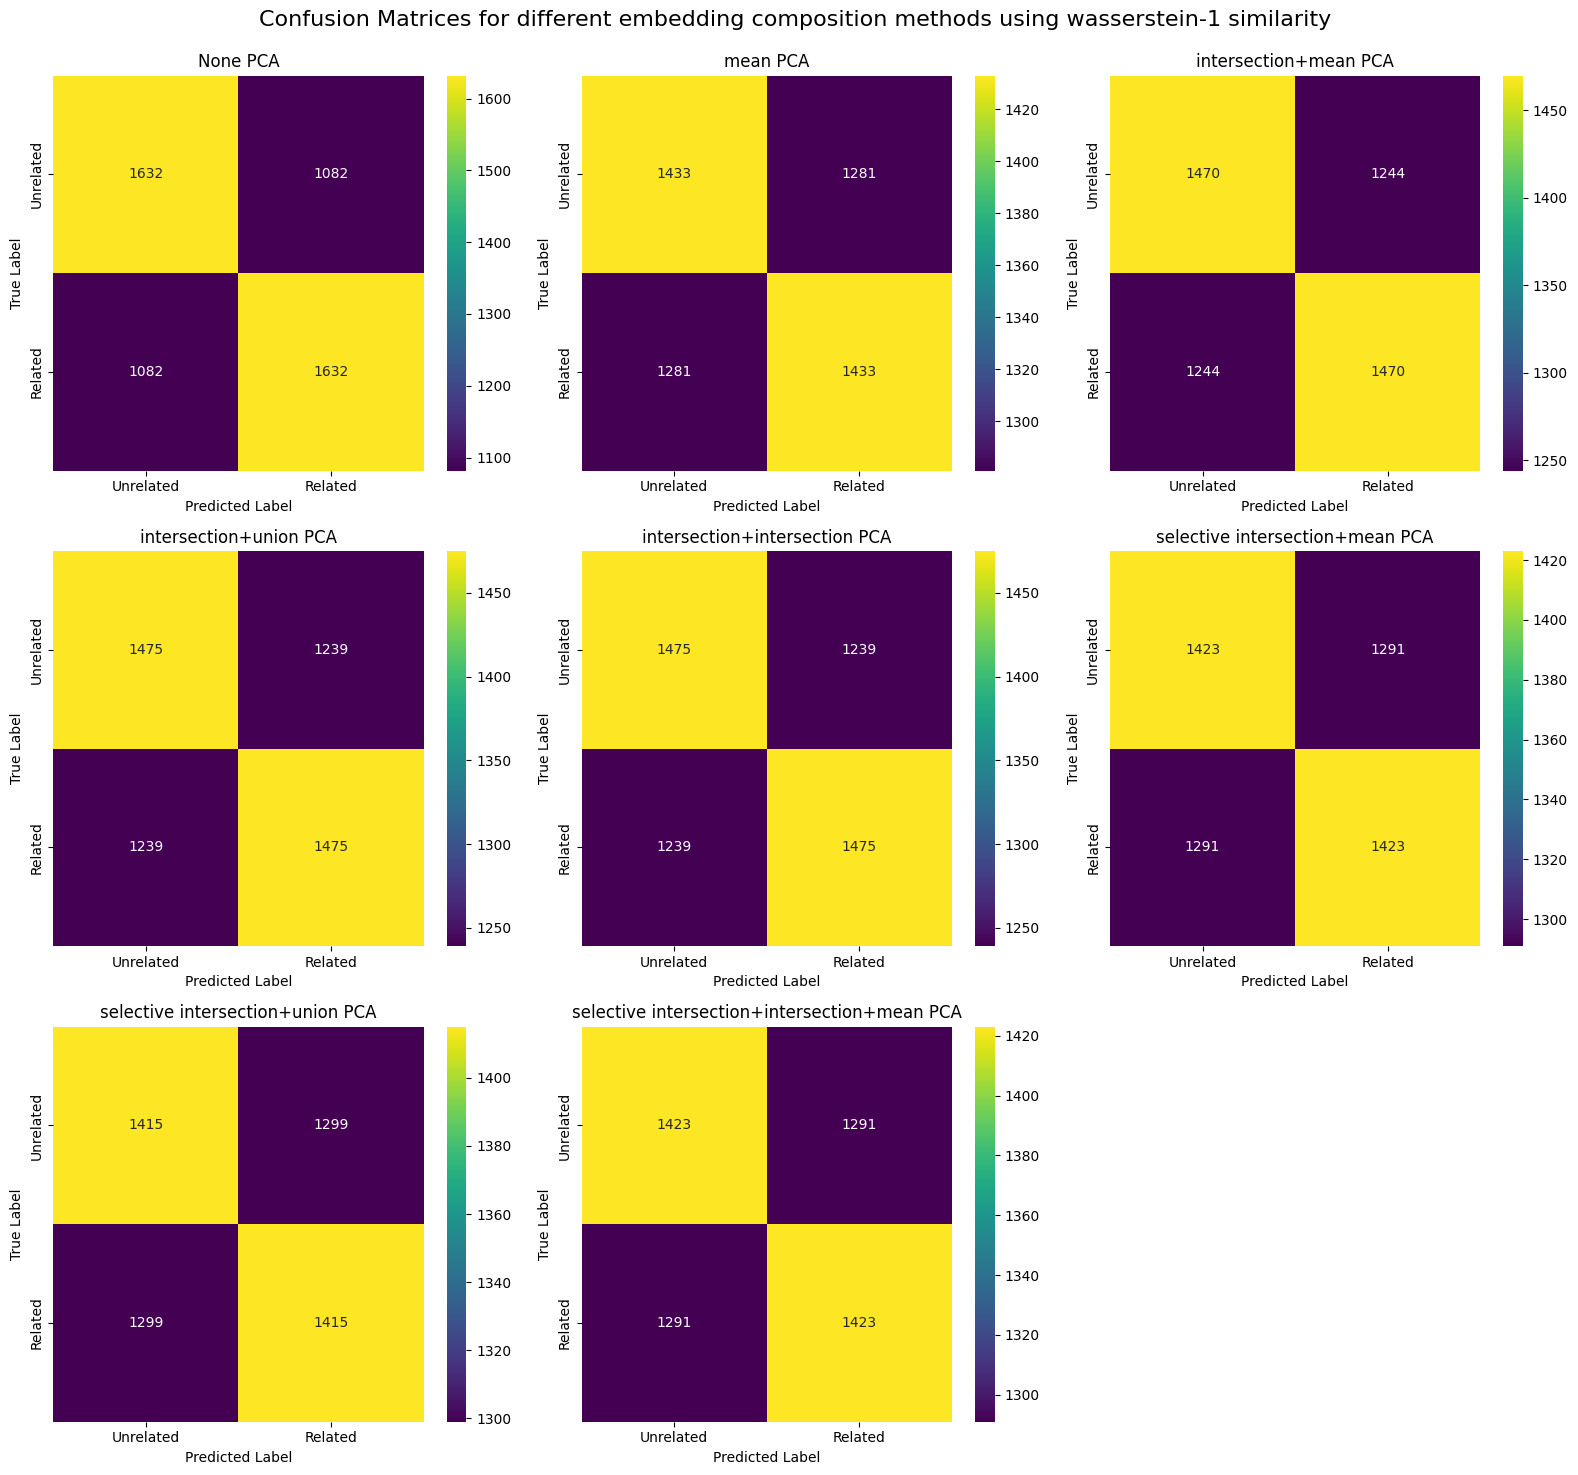

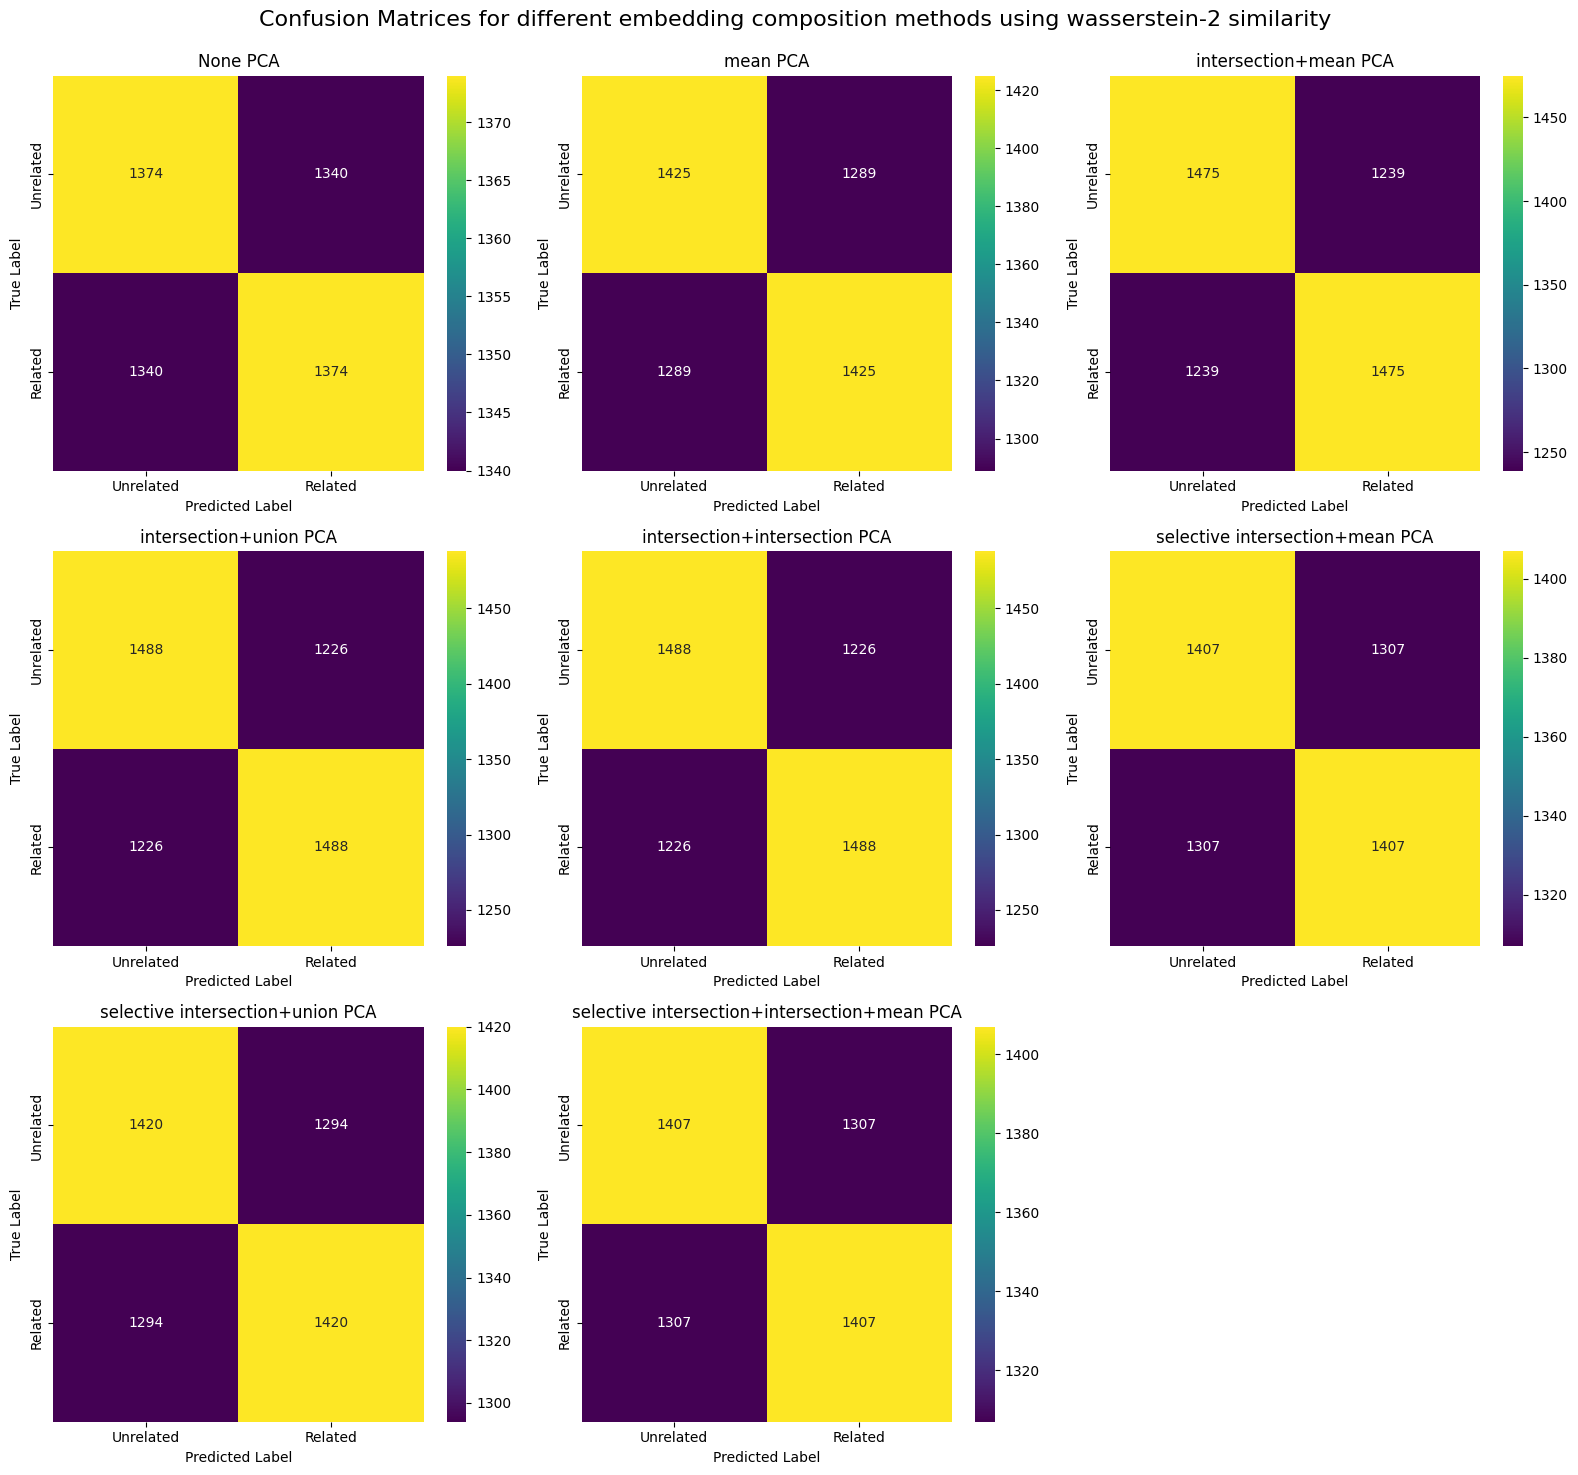

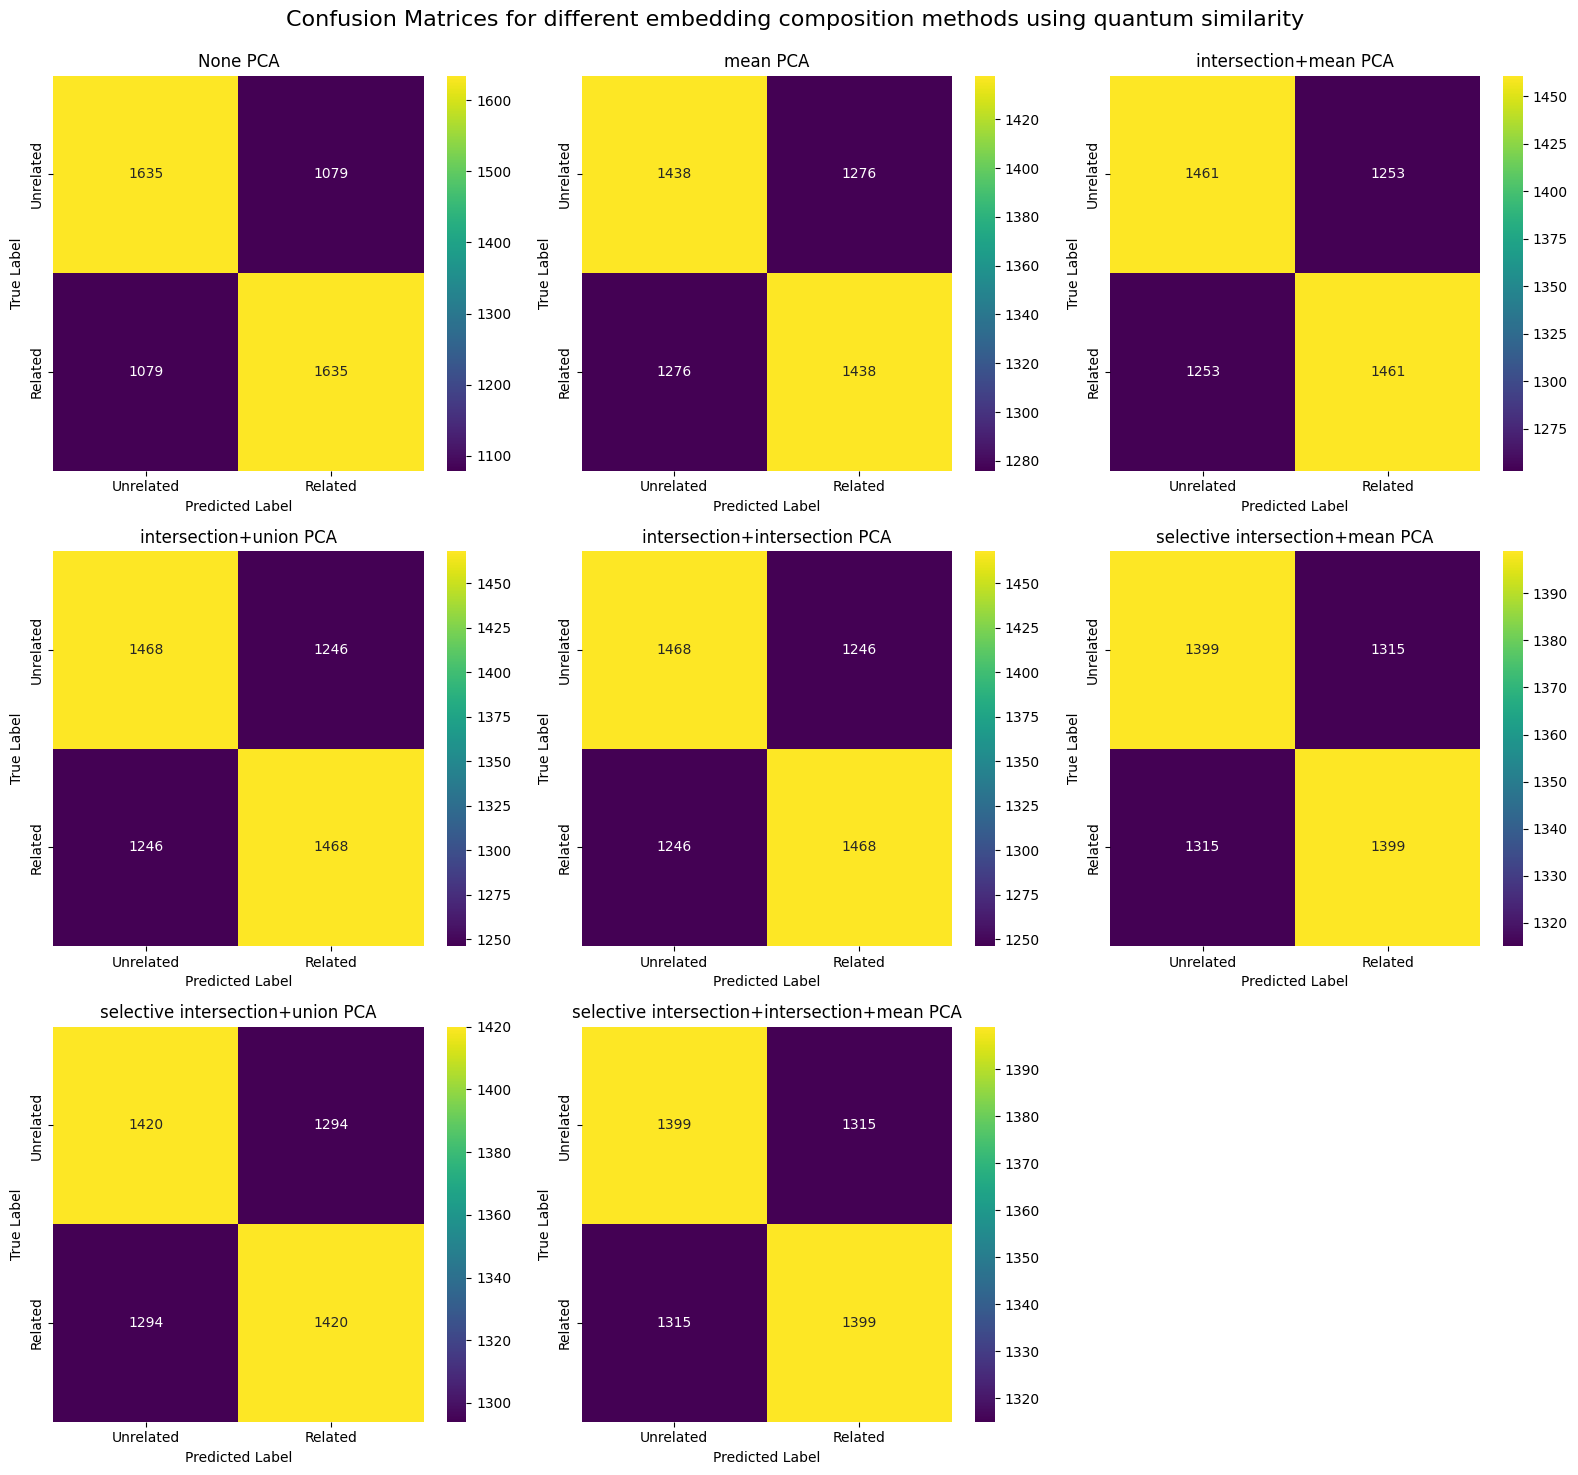

In [26]:
# Create confusion matrices for all metrics
for sim_metric in sim_metrics:
    # Get columns for this metric
    metric_cols = [col for col in sim_eval_df.columns if col.endswith(f"{sim_metric}_sim_pred")]
    
    if not metric_cols:
        continue
    
    # Calculate grid size
    n_cols = 3
    n_rows = int(np.ceil(len(metric_cols) / n_cols))
    
    plt.figure(figsize=(16, 5*n_rows))
    plt.suptitle(f"Confusion Matrices for different embedding composition methods using {sim_metric} similarity\n", fontsize=16)
    
    for i, col in enumerate(metric_cols):
        # Calculate confusion matrix
        cm = confusion_matrix(
            sim_eval_df['is_related'],
            sim_eval_df[col].astype(int)
        )

        # Plot confusion matrix
        plt.subplot(n_rows, n_cols, i+1)
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='viridis',
            xticklabels=['Unrelated', 'Related'],
            yticklabels=['Unrelated', 'Related']
        )
        plt.title(f'{col.replace("fuzzy_", "").replace(f"_{sim_metric}_sim_pred", "").replace("_", " ")}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')

    plt.tight_layout()
    plt.show()

## Correlation Coefficients

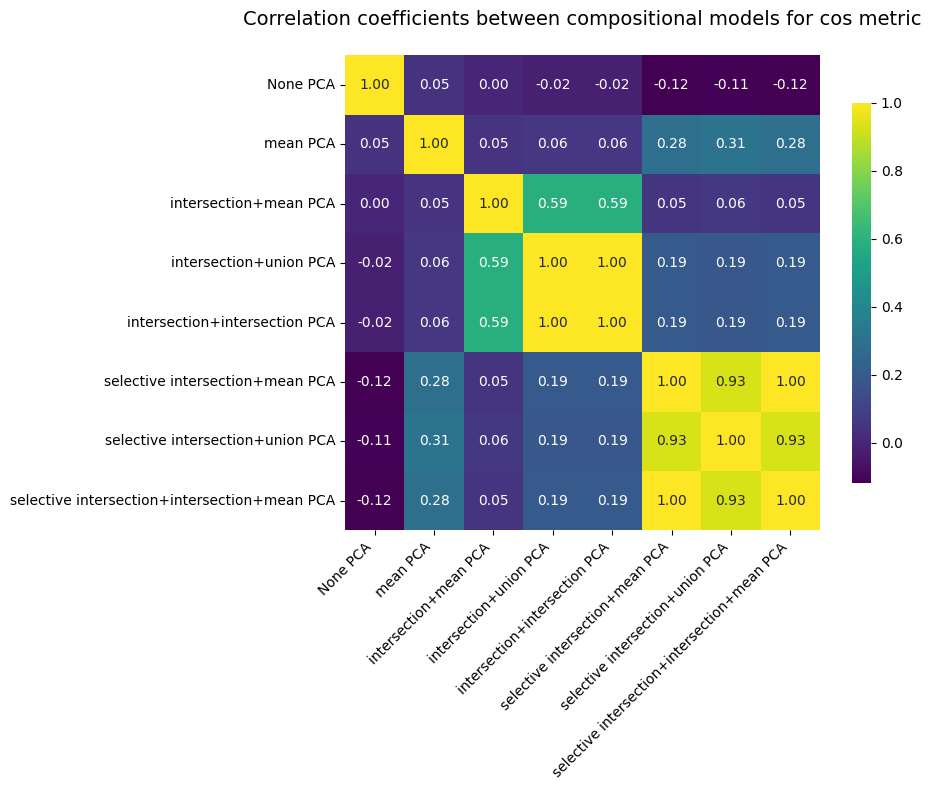

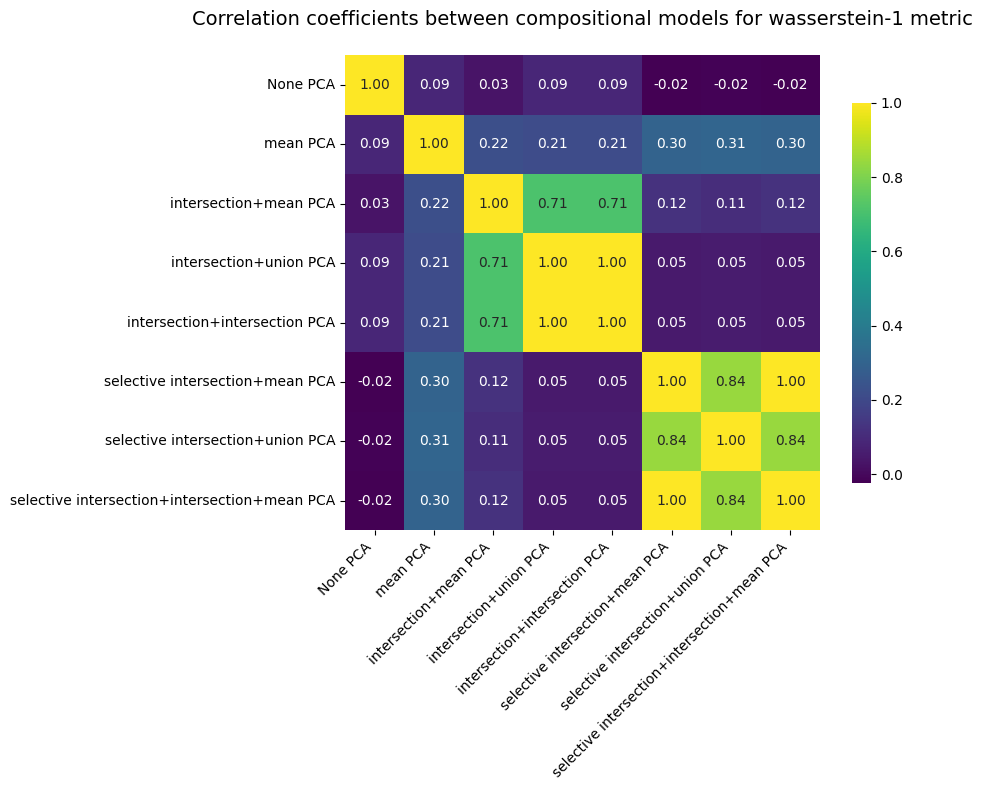

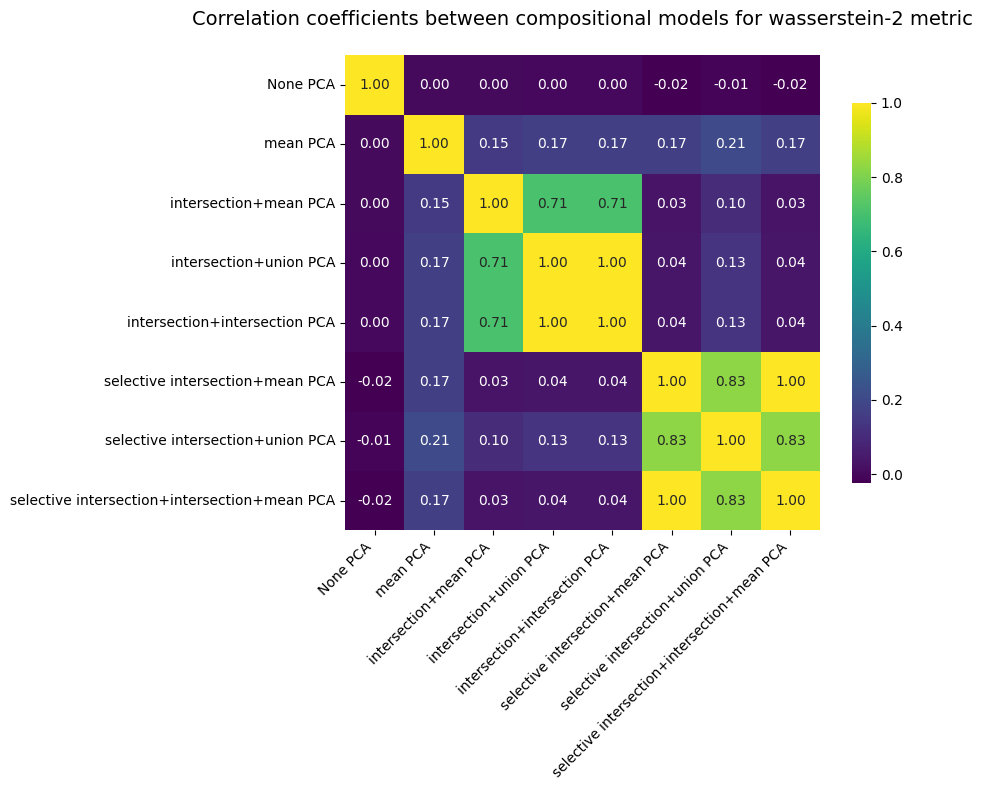

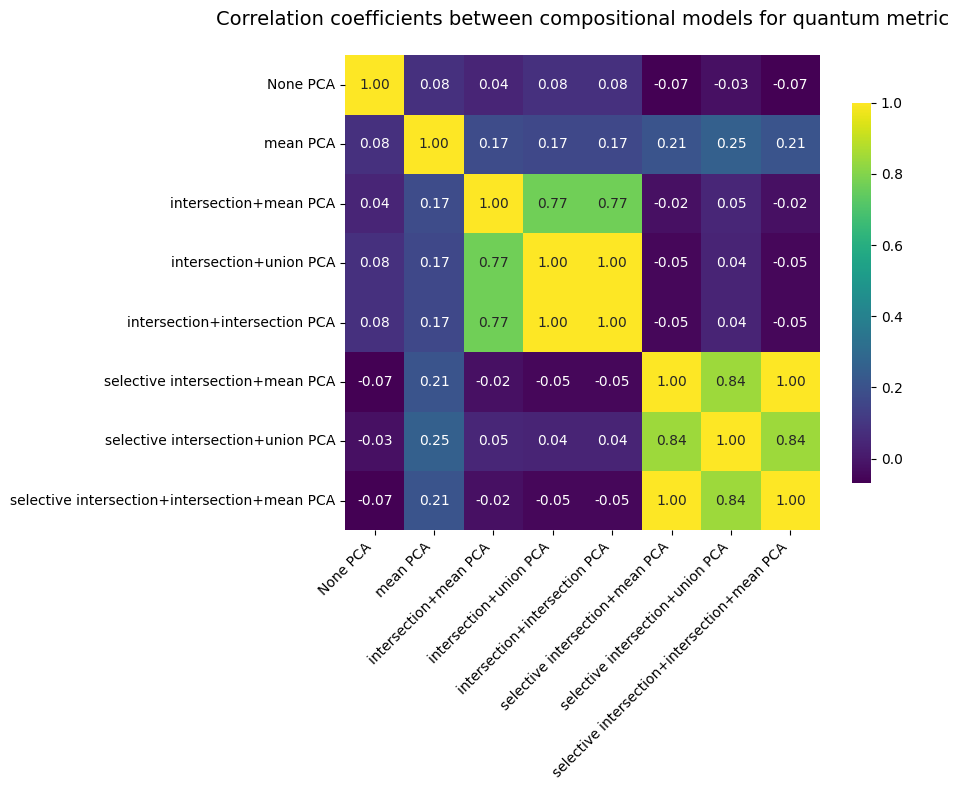

In [27]:
# Create correlation heatmaps for each metric
for sim_metric in sim_metrics:
    # Get prediction columns for this metric
    metric_pred_cols = [c for c in sim_eval_df.columns if c.endswith(f"{sim_metric}_sim_pred")] + ["is_related"]
    # filter to just PCA columns, to avoid an eyesore
    metric_pred_cols = [c for c in metric_pred_cols if "_PCA" in c]

    if len(metric_pred_cols) <= 1:
        continue
    
    # Calculate correlation matrix
    corr_matrix = sim_eval_df[metric_pred_cols].corr()
    
    # Create figure with proper size
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create heatmap
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt='.2f',
        cmap='viridis',
        ax=ax,
        square=True,
        cbar_kws={"shrink": 0.8}
    )
    
    # Simplify labels
    labels = [
        label.replace(f"fuzzy_", "")\
            .replace(f"_{sim_metric}_sim_pred", "")\
            .replace("_", " ")
        for label in corr_matrix.columns
    ]
    
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels(labels, rotation=0, fontsize=10)
    
    plt.title(f"Correlation coefficients between compositional models for {sim_metric} metric\n", fontsize=14)
    plt.tight_layout()
    plt.show()

## F1, Recall, Precision, Accuracy, etc.

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create evaluation metrics dataframe for ALL similarity metrics
metrics_data = []

for col in sim_eval_df.columns:
    if col == "is_related":
        continue
    y_true = sim_eval_df['is_related']
    y_pred = sim_eval_df[col].astype(int)
    
    # Extract metric name from column
    metric_name = None
    for sim_metric in sim_metrics:
        if f"_{sim_metric}_sim_pred" in col:
            metric_name = sim_metric
            break
        
    strategy = col.replace('_pred', '').replace(f'_{metric_name}_sim', '').replace('fuzzy_', '')
    
    metrics_data.append({
        'strategy': strategy,
        'similarity_metric': metric_name,
        'model': col.replace('_pred', ''),
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1_score': f1_score(y_true, y_pred, zero_division=0)
    })

metrics_df = pd.DataFrame(metrics_data)
metrics_df = metrics_df.sort_values(['f1_score', 'similarity_metric', ], ascending=[False, True]).reset_index(drop=True)
metrics_df[:10]

,strategy,similarity_metric,model,accuracy,precision,recall,f1_score
0,sent_emb,cos,sent_emb_cos_sim,0.606485,0.606485,0.606485,0.606485
1,None_PCA,quantum,fuzzy_None_PCA_quantum_sim,0.602432,0.602432,0.602432,0.602432
2,None_PCA,wasserstein-1,fuzzy_None_PCA_wasserstein-1_sim,0.601326,0.601326,0.601326,0.601326
3,sbert_token_avg,cos,sbert_token_avg_cos_sim,0.584377,0.584377,0.584377,0.584377
4,None_PCA,cos,fuzzy_None_PCA_cos_sim,0.581430,0.581430,0.581430,0.581430
5,intersection+union_PCA,wasserstein-2,fuzzy_intersection+union_PCA_wasserstein-2_sim,0.548268,0.548268,0.548268,0.548268
6,intersection+intersection_PCA,wasserstein-2,fuzzy_intersection+intersection_PCA_wasserstei...,0.548268,0.548268,0.548268,0.548268
7,intersection+union_PCA,wasserstein-1,fuzzy_intersection+union_PCA_wasserstein-1_sim,0.543478,0.543478,0.543478,0.543478
8,intersection+intersection_PCA,wasserstein-1,fuzzy_intersection+intersection_PCA_wasserstei...,0.543478,0.543478,0.543478,0.543478
9,intersection+mean_PCA,wasserstein-2,fuzzy_intersection+mean_PCA_wasserstein-2_sim,0.543478,0.543478,0.543478,0.543478


In [29]:
# Create bar graphs for each similarity metric
metric_names = ['accuracy', 'precision', 'recall', 'f1_score']
metric_titles = ['Accuracy', 'Precision', 'Recall', 'F1 Score']


# Get baseline values for sent_emb_cos_sim
baseline_data = metrics_df[metrics_df['strategy'] == 'sent_emb']
baseline_values = {
    'accuracy': baseline_data['accuracy'].values[0] if len(baseline_data) > 0 else None,
    'precision': baseline_data['precision'].values[0] if len(baseline_data) > 0 else None,
    'recall': baseline_data['recall'].values[0] if len(baseline_data) > 0 else None,
    'f1_score': baseline_data['f1_score'].values[0] if len(baseline_data) > 0 else None
}


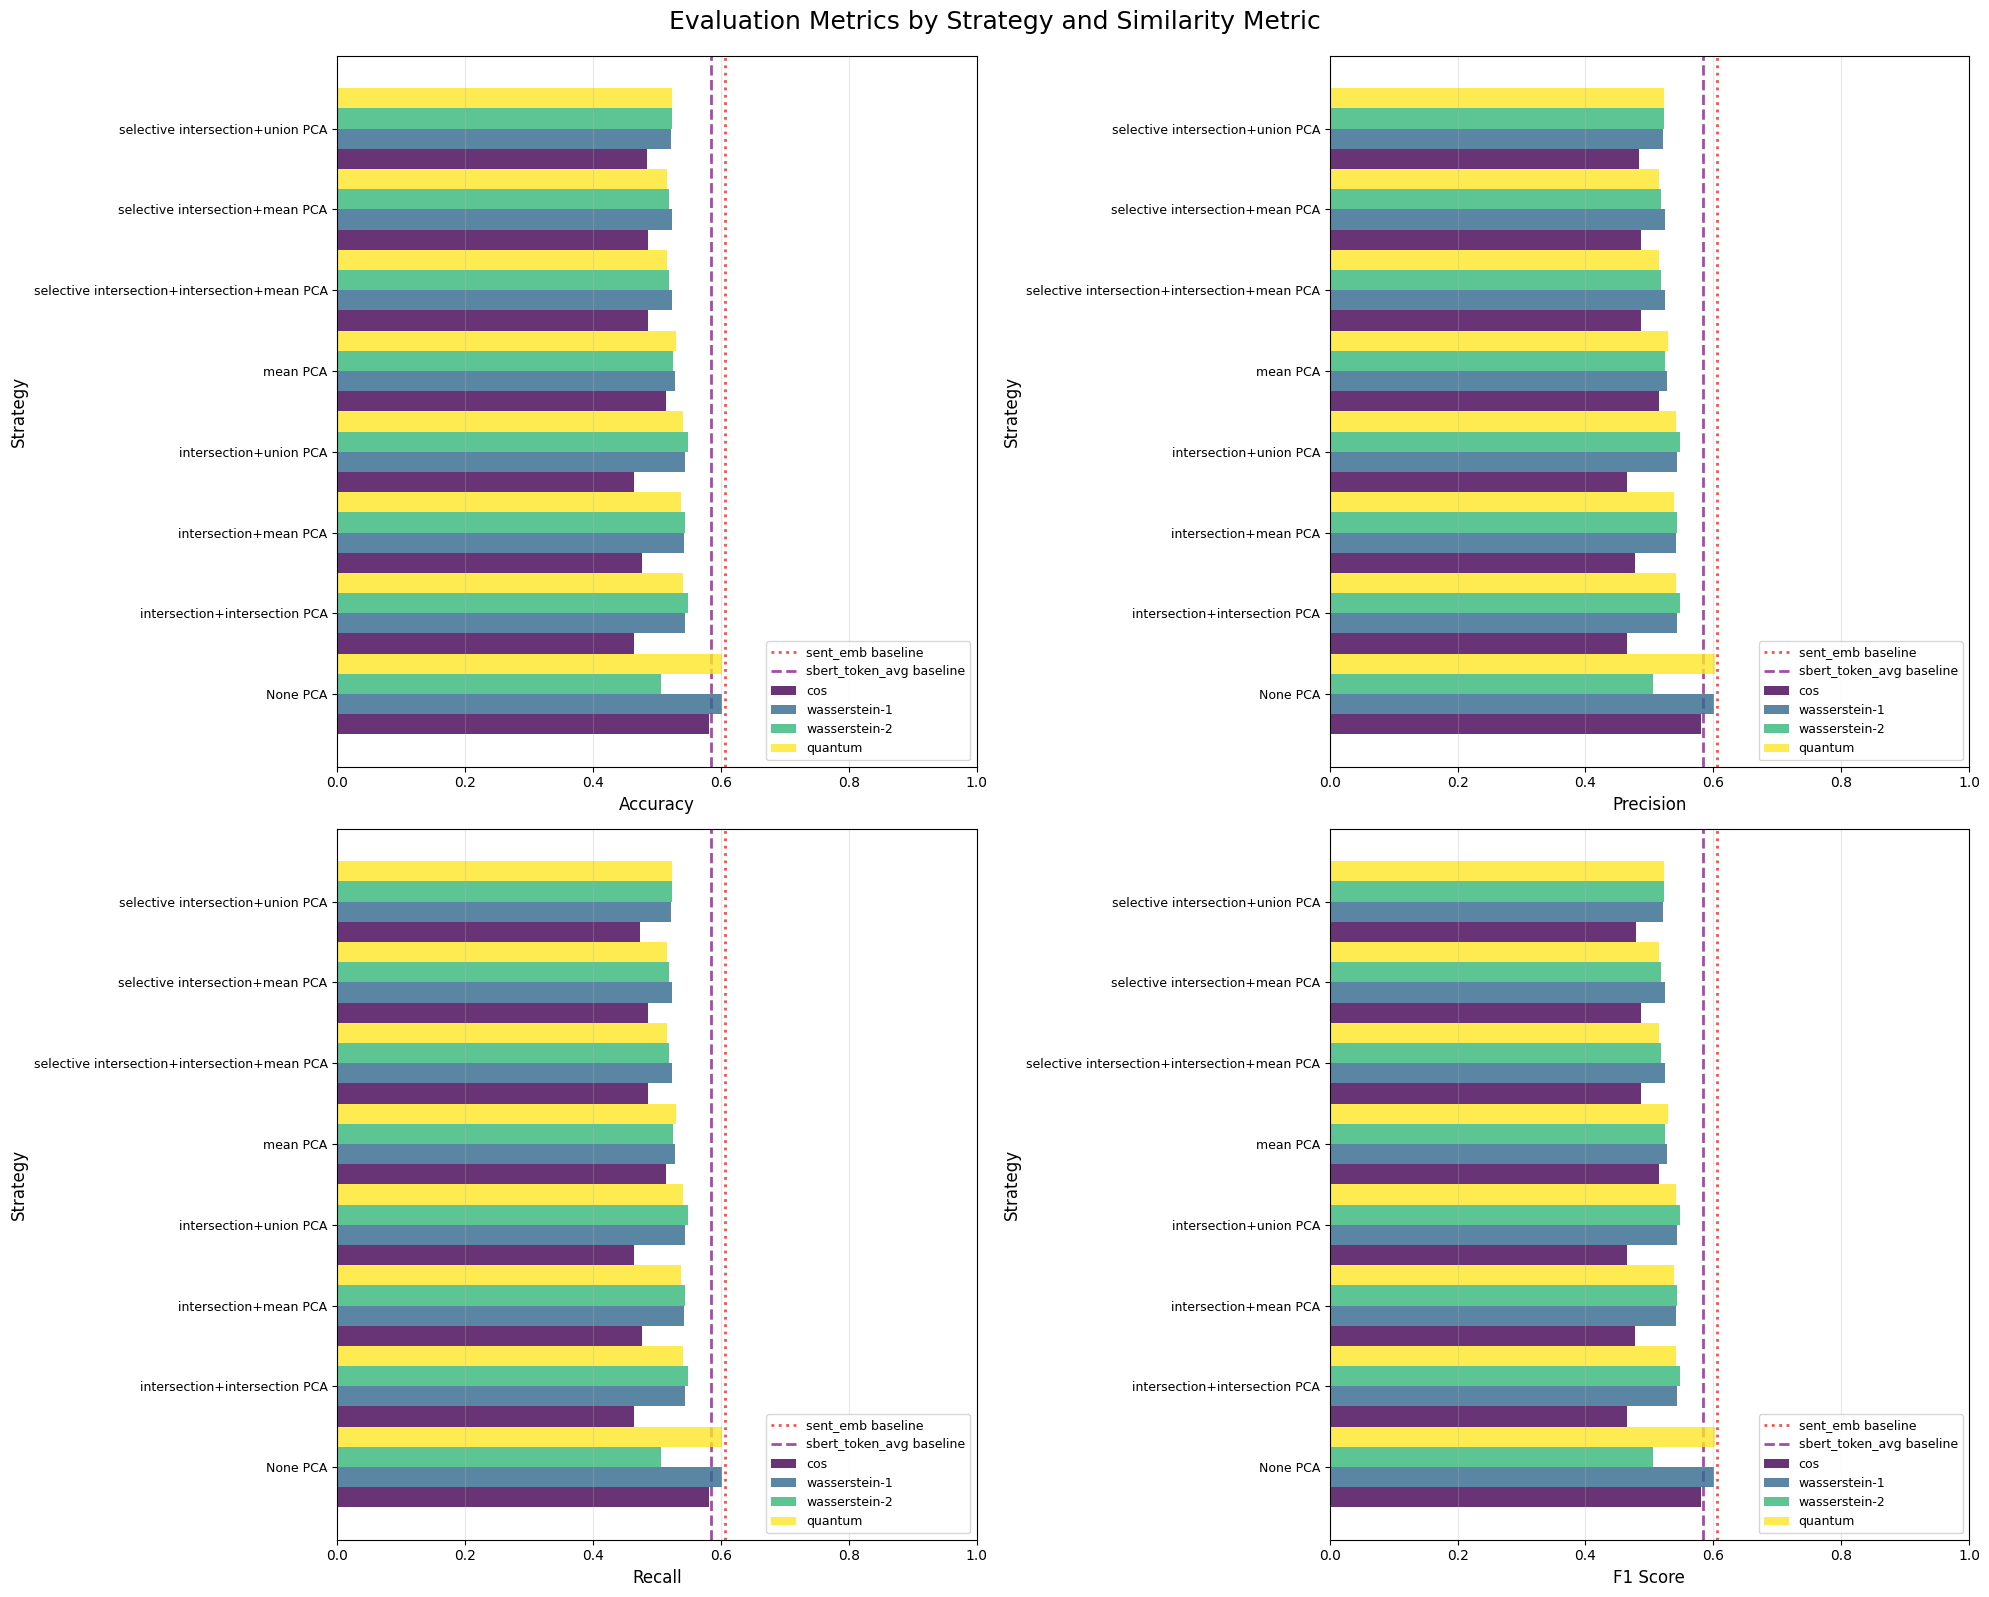

In [30]:
# Create combined bar graphs with different colors for each similarity metric
metric_names = ['accuracy', 'precision', 'recall', 'f1_score']
metric_titles = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Define colors for each similarity metric
sim_metric_colors = {
    'npsd-ot': 'steelblue',
    'p-ot': 'coral',
    'cos': 'mediumseagreen'
}

# Get baseline values
baseline_data = metrics_df[metrics_df['strategy'] == 'sent_emb']
sbert_token_data = metrics_df[metrics_df['strategy'] == 'sbert_token_avg']

baseline_values = {
    'accuracy': baseline_data['accuracy'].values[0] if len(baseline_data) > 0 else None,
    'precision': baseline_data['precision'].values[0] if len(baseline_data) > 0 else None,
    'recall': baseline_data['recall'].values[0] if len(baseline_data) > 0 else None,
    'f1_score': baseline_data['f1_score'].values[0] if len(baseline_data) > 0 else None
}

sbert_token_values = {
    'accuracy': sbert_token_data['accuracy'].values[0] if len(sbert_token_data) > 0 else None,
    'precision': sbert_token_data['precision'].values[0] if len(sbert_token_data) > 0 else None,
    'recall': sbert_token_data['recall'].values[0] if len(sbert_token_data) > 0 else None,
    'f1_score': sbert_token_data['f1_score'].values[0] if len(sbert_token_data) > 0 else None
}

# Get all unique strategies (excluding baselines and None strategy)
all_strategies = sorted(metrics_df[
    (~metrics_df['strategy'].isin(['sent_emb', 'sbert_token_avg', 'None']))
]['strategy'].unique())

# Create one figure with 4 subplots (one for each metric)
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Evaluation Metrics by Strategy and Similarity Metric', fontsize=18, y=0.995)

# Create a viridis color map for similarity metrics
cmap = plt.cm.viridis
sim_metric_colors = {
    sim_metric: cmap(i / max(len(sim_metrics) - 1, 1))
    for i, sim_metric in enumerate(sim_metrics)
}

for idx, (metric, title) in enumerate(zip(metric_names, metric_titles)):
    ax = axes[idx // 2, idx % 2]
    
    # Prepare data for grouped bar chart
    bar_width = 0.25
    x_pos = np.arange(len(all_strategies))
    
    # Plot bars for each similarity metric
    for i, sim_metric in enumerate(sim_metrics):
        metric_data = metrics_df[
            (metrics_df['similarity_metric'] == sim_metric) & 
            (metrics_df['strategy'].isin(all_strategies))
        ].set_index('strategy')
        
        # Reindex to match all_strategies order
        metric_data = metric_data.reindex(all_strategies)
        values = metric_data[metric].values
        
        # Plot bars with offset
        offset = (i - len(sim_metrics)/2 + 0.5) * bar_width
        bars = ax.barh(
            x_pos + offset,
            values,
            bar_width,
            label=sim_metric,
            color=sim_metric_colors[sim_metric],
            alpha=0.8
        )

    
    # Add baseline lines
    if baseline_values[metric] is not None:
        ax.axvline(x=baseline_values[metric], color='red', linestyle=':', linewidth=2,
                  label='sent_emb baseline', alpha=0.7, zorder=0)
    
    if sbert_token_values[metric] is not None:
        ax.axvline(x=sbert_token_values[metric], color='purple', linestyle='--', linewidth=2,
                  label='sbert_token_avg baseline', alpha=0.7, zorder=0)
    
    ax.set_yticks(x_pos)
    ax.set_yticklabels([s.replace('_', ' ') for s in all_strategies], fontsize=9)
    ax.set_xlabel(title, fontsize=12)
    ax.set_ylabel('Strategy', fontsize=12)
    ax.set_xlim(0, 1.0)
    ax.grid(axis='x', alpha=0.3)
    ax.legend(loc='lower right', fontsize=9)

plt.tight_layout()
plt.show()

In [31]:
metrics_df.to_csv(f"full_train_eval-wn_free-n_components={n_components}-kernel_size={fuzzification_kernel_size}.tsv", sep="\t")